In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm
import scipy

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [2]:
def word_to_int(df):
    # Red = 1, blue = 0
    df["class"] = 1
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 0
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)


In [3]:
def plot_data(df, ax, suptitle):
    ax.set_title(suptitle)
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.5, ax=ax)
    
    df_blue = df[df["color"] == "blue"]
    sn.scatterplot(df_blue, x="x1", y = "x2", c="blue", alpha=0.5, ax=ax)
    #legacy
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="blue", alpha=0.5, ax=ax)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

    return ax

In [4]:
def plot_results(df, ax, suptitle, errors = False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()

    if errors:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="Confidence", 
                       size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="Confidence", 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    palette=cmap, legend=False)
    
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

    return ax


In [31]:
def predict_grid(model, x1_key, x2_key, device, mcdropout:bool = False, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)
    if mcdropout:
        mean_val, variance_val = mc_predictions(model, gridtest_dataset, 2**8, 100, 2, len(df))
        preds = np.argmax(mean_val, axis=-1).flatten()
        df["Prediction"] = preds
        #Get average softmax score for blue
        df["Confidence"] = scipy.special.softmax(mean_val, axis=-1)[:,0]
        # Error is the same for both scores
        df["Error"] = np.sqrt(variance_val[:,0])
    else:
        truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        df["Prediction"] = preds
        #Get softmax score for red
        df["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
    return df

In [6]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [2]:
# Read data
trainfile = "train_n_5000_kr7_kb3_s1_vary_a1_False"
valfile = "val_n_5000_kr7_kb3_s1_vary_a1_False"
testfile = "x1_x2_grid"
#ntrain = 250

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")

#Convert test to polar
test_data = cartesian_to_polar_df(test_data, "x1", "x2", "r_x", "a_x")

#Choose
ntrain = len(train_data)
x1_key = "r_x"
x2_key = "a_x"

train_data = word_to_int(train_data)
val_data = word_to_int(val_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

NameError: name 'pd' is not defined

In [ ]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)

In [ ]:
model = SequentialNet(L=1024, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 100/100 [00:00<00:00, 505.11it/s]


Text(0.5, 0.98, 'Number of datapoints: 0')

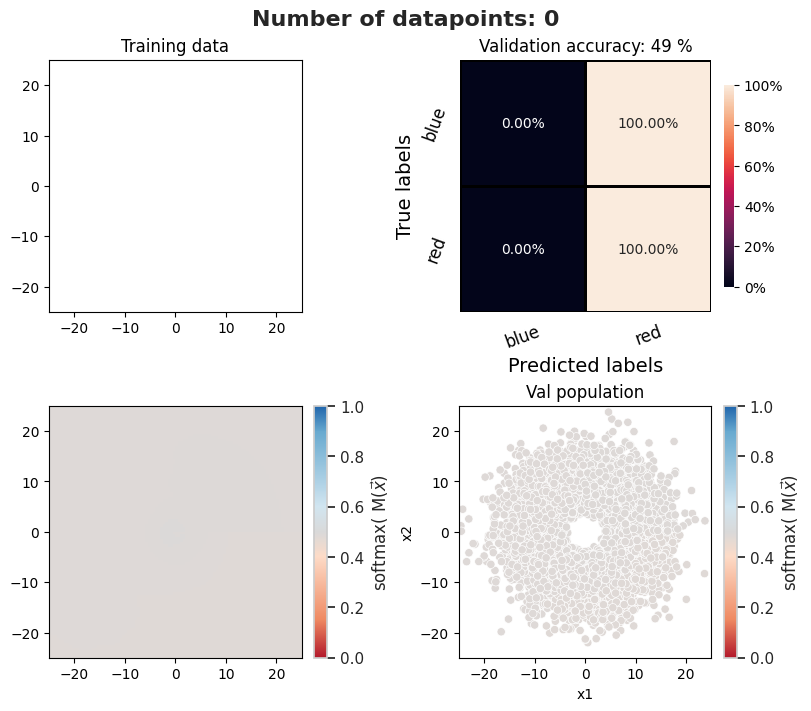

In [ ]:
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0]

# Save prediction
#

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_data(train_data[0:0], axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[0][1])
grid_df = predict_grid(model, x1_key, x2_key, device)
fig, axs[1][0] = plot_grid(grid_df, fig, axs[1][0])
axs[1][1] = plot_results(val_data, axs[1][1], "Val population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Number of datapoints: 0", size=16, fontweight="bold")

100%|██████████| 50/50 [00:00<00:00, 508.67it/s]


<Axes: xlabel='Iteration'>

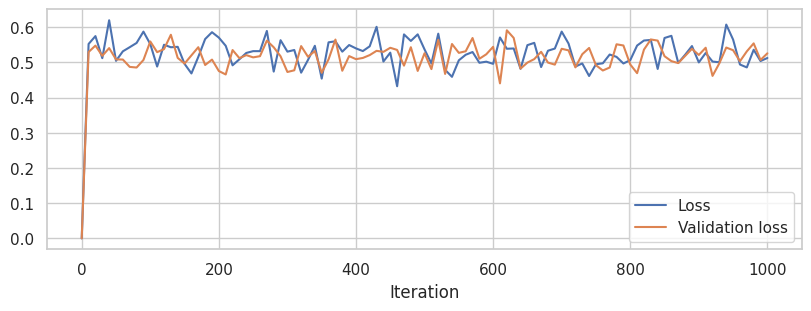

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train[0:ntrain], Y_train[0:ntrain])
training_results = train_classifier(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 50, 
                         device = device, optimizer = optimizer)
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs)

100%|██████████| 100/100 [00:00<00:00, 505.86it/s]


Text(0.5, 0.98, 'Number of datapoints: 5000')

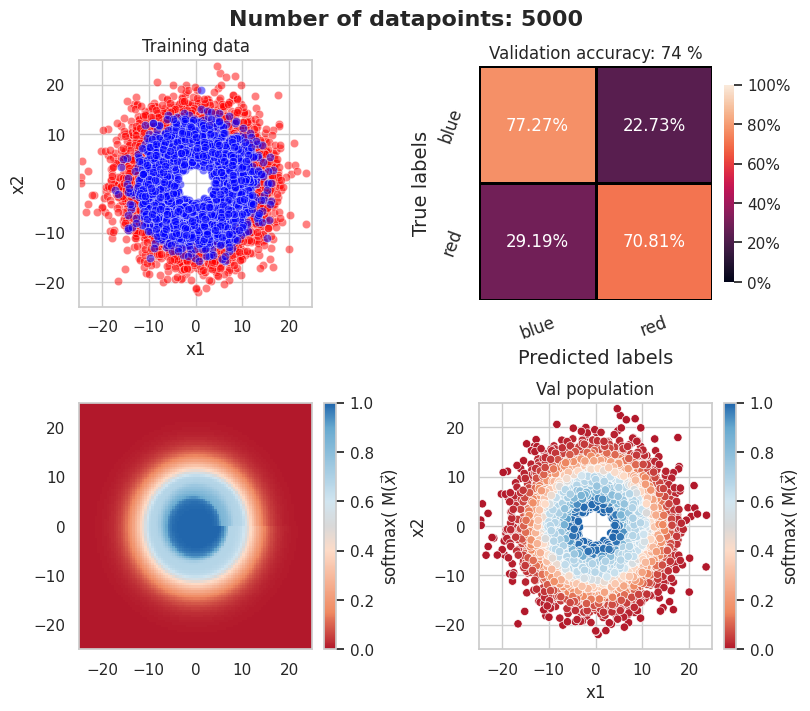

In [ ]:
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0]


fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_data(train_data[0:ntrain], axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[0][1])
grid_df = predict_grid(model, x1_key, x2_key, device)
fig, axs[1][0] = plot_grid(grid_df, fig, axs[1][0])
axs[1][1] = plot_results(val_data, axs[1][1], "Val population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Number of datapoints: {ntrain}", size=16, fontweight="bold")

In [ ]:
mean_val, variance_val = mc_predictions(model, val_dataset, 2**8, 200, 2, len(val_dataset))
preds = np.argmax(mean_val, axis=-1).flatten()
val_data["Prediction"] = preds
#Get average softmax score for blue
val_data["Confidence"] = scipy.special.softmax(mean_val, axis=-1)[:,0]
# Error is the same for both scores
val_data["Error"] = np.sqrt(variance_val[:,0])


Text(0.5, 0.98, 'Number of datapoints: 5000')

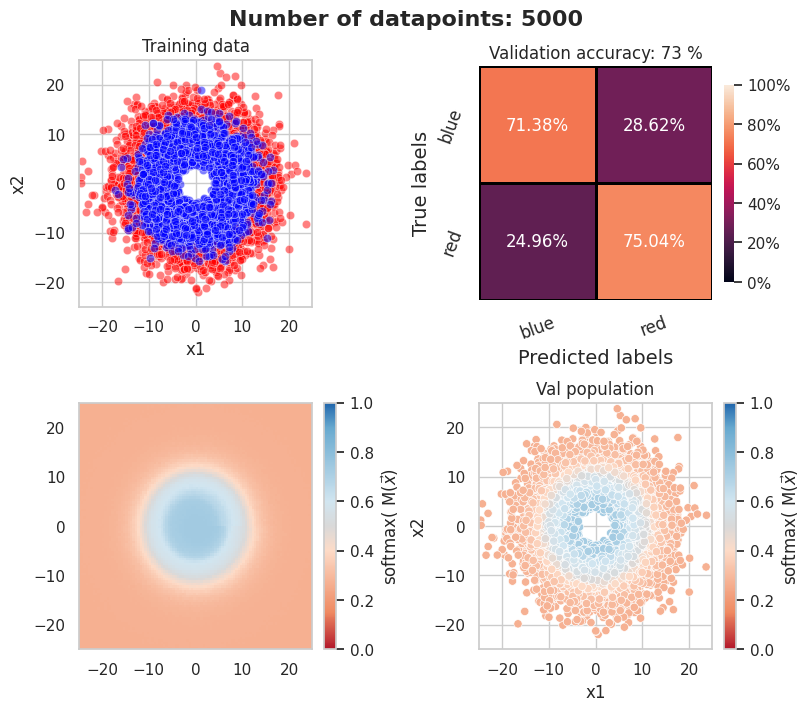

In [ ]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_data(train_data[0:ntrain], axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[0][1])
grid_df = predict_grid(model, x1_key, x2_key, device, mcdropout=True)
fig, axs[1][0] = plot_grid(grid_df, fig, axs[1][0])
axs[1][1] = plot_results(val_data, axs[1][1], "Val population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Number of datapoints: {ntrain}", size=16, fontweight="bold")